# Volatility Surface Parameters Simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from notebooks.utils import BS_PUT, sigma_model

In [2]:
beta = pd.read_parquet('../data.nosync/beta.parquet')
beta

,date,beta1,beta2,beta3,beta4,beta5
0,2000-08-31,0.209443,-0.033085,0.003102,-0.005289,-0.002869
1,2000-09-01,0.206923,-0.017983,0.006191,-0.011377,-0.006313
2,2000-09-05,0.194020,0.067232,0.015366,-0.020927,-0.003105
3,2000-09-06,0.205208,0.000788,0.018398,-0.026022,-0.003734
4,2000-09-07,0.198713,0.029166,0.025915,-0.033422,-0.000516
...,...,...,...,...,...,...
5781,2023-08-25,0.201611,-0.142457,0.225539,-0.029057,-0.045927
5782,2023-08-28,0.202365,-0.149166,0.222393,-0.026056,-0.044353
5783,2023-08-29,0.199807,-0.155747,0.214850,-0.033763,-0.052378
5784,2023-08-30,0.200782,-0.165996,0.212386,-0.035851,-0.050152


## Data Preparation

We work with the parameter vector $\beta_t$:
$$
\beta_t=\left(\beta_{1, t}\quad \beta_{2, t}\quad \beta_{3, t}\quad \beta_{4, t}\quad \beta_{5, t}\right)\in\mathbb{R}^5
$$
that we scale and use as observations for our hidden Markov model

In [3]:
beta_cols = ["beta1", "beta2", "beta3", "beta4", "beta5"]
B = beta[beta_cols].to_numpy()
dates = beta["date"].to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(B)

## Hidden Markov Model

We fit a two state Gaussian hidden Markov model to the standardized beta timeseries.

In [4]:
hmm = GaussianHMM(
    n_components=2,
    covariance_type="full",
    n_iter=500,
    random_state=0
)
hmm.fit(X)
_, post = hmm.score_samples(X)
p_crisis = post[:, 1]
transmat = hmm.transmat_
transmat

array([[0.99366889, 0.00633111],
       [0.00945462, 0.99054538]])

## Crisis identification

We extract the crisis posterior probability:
$$
p_t=\mathbb{P}\left(S_t=1\mid X_{1:t}\right)
$$
We then classify days as crisis if the probability is above a selected threshold.

In [5]:
thr = 0.9
beta["p_crisis"] = p_crisis
beta["state"] = (p_crisis >= thr).astype(int)
beta

,date,beta1,beta2,beta3,beta4,beta5,p_crisis,state
0,2000-08-31,0.209443,-0.033085,0.003102,-0.005289,-0.002869,1.000000e+00,1
1,2000-09-01,0.206923,-0.017983,0.006191,-0.011377,-0.006313,1.000000e+00,1
2,2000-09-05,0.194020,0.067232,0.015366,-0.020927,-0.003105,1.000000e+00,1
3,2000-09-06,0.205208,0.000788,0.018398,-0.026022,-0.003734,1.000000e+00,1
4,2000-09-07,0.198713,0.029166,0.025915,-0.033422,-0.000516,1.000000e+00,1
...,...,...,...,...,...,...,...,...
5781,2023-08-25,0.201611,-0.142457,0.225539,-0.029057,-0.045927,4.408878e-07,0
5782,2023-08-28,0.202365,-0.149166,0.222393,-0.026056,-0.044353,6.304921e-07,0
5783,2023-08-29,0.199807,-0.155747,0.214850,-0.033763,-0.052378,2.056093e-07,0
5784,2023-08-30,0.200782,-0.165996,0.212386,-0.035851,-0.050152,3.033474e-06,0


## Visualisation

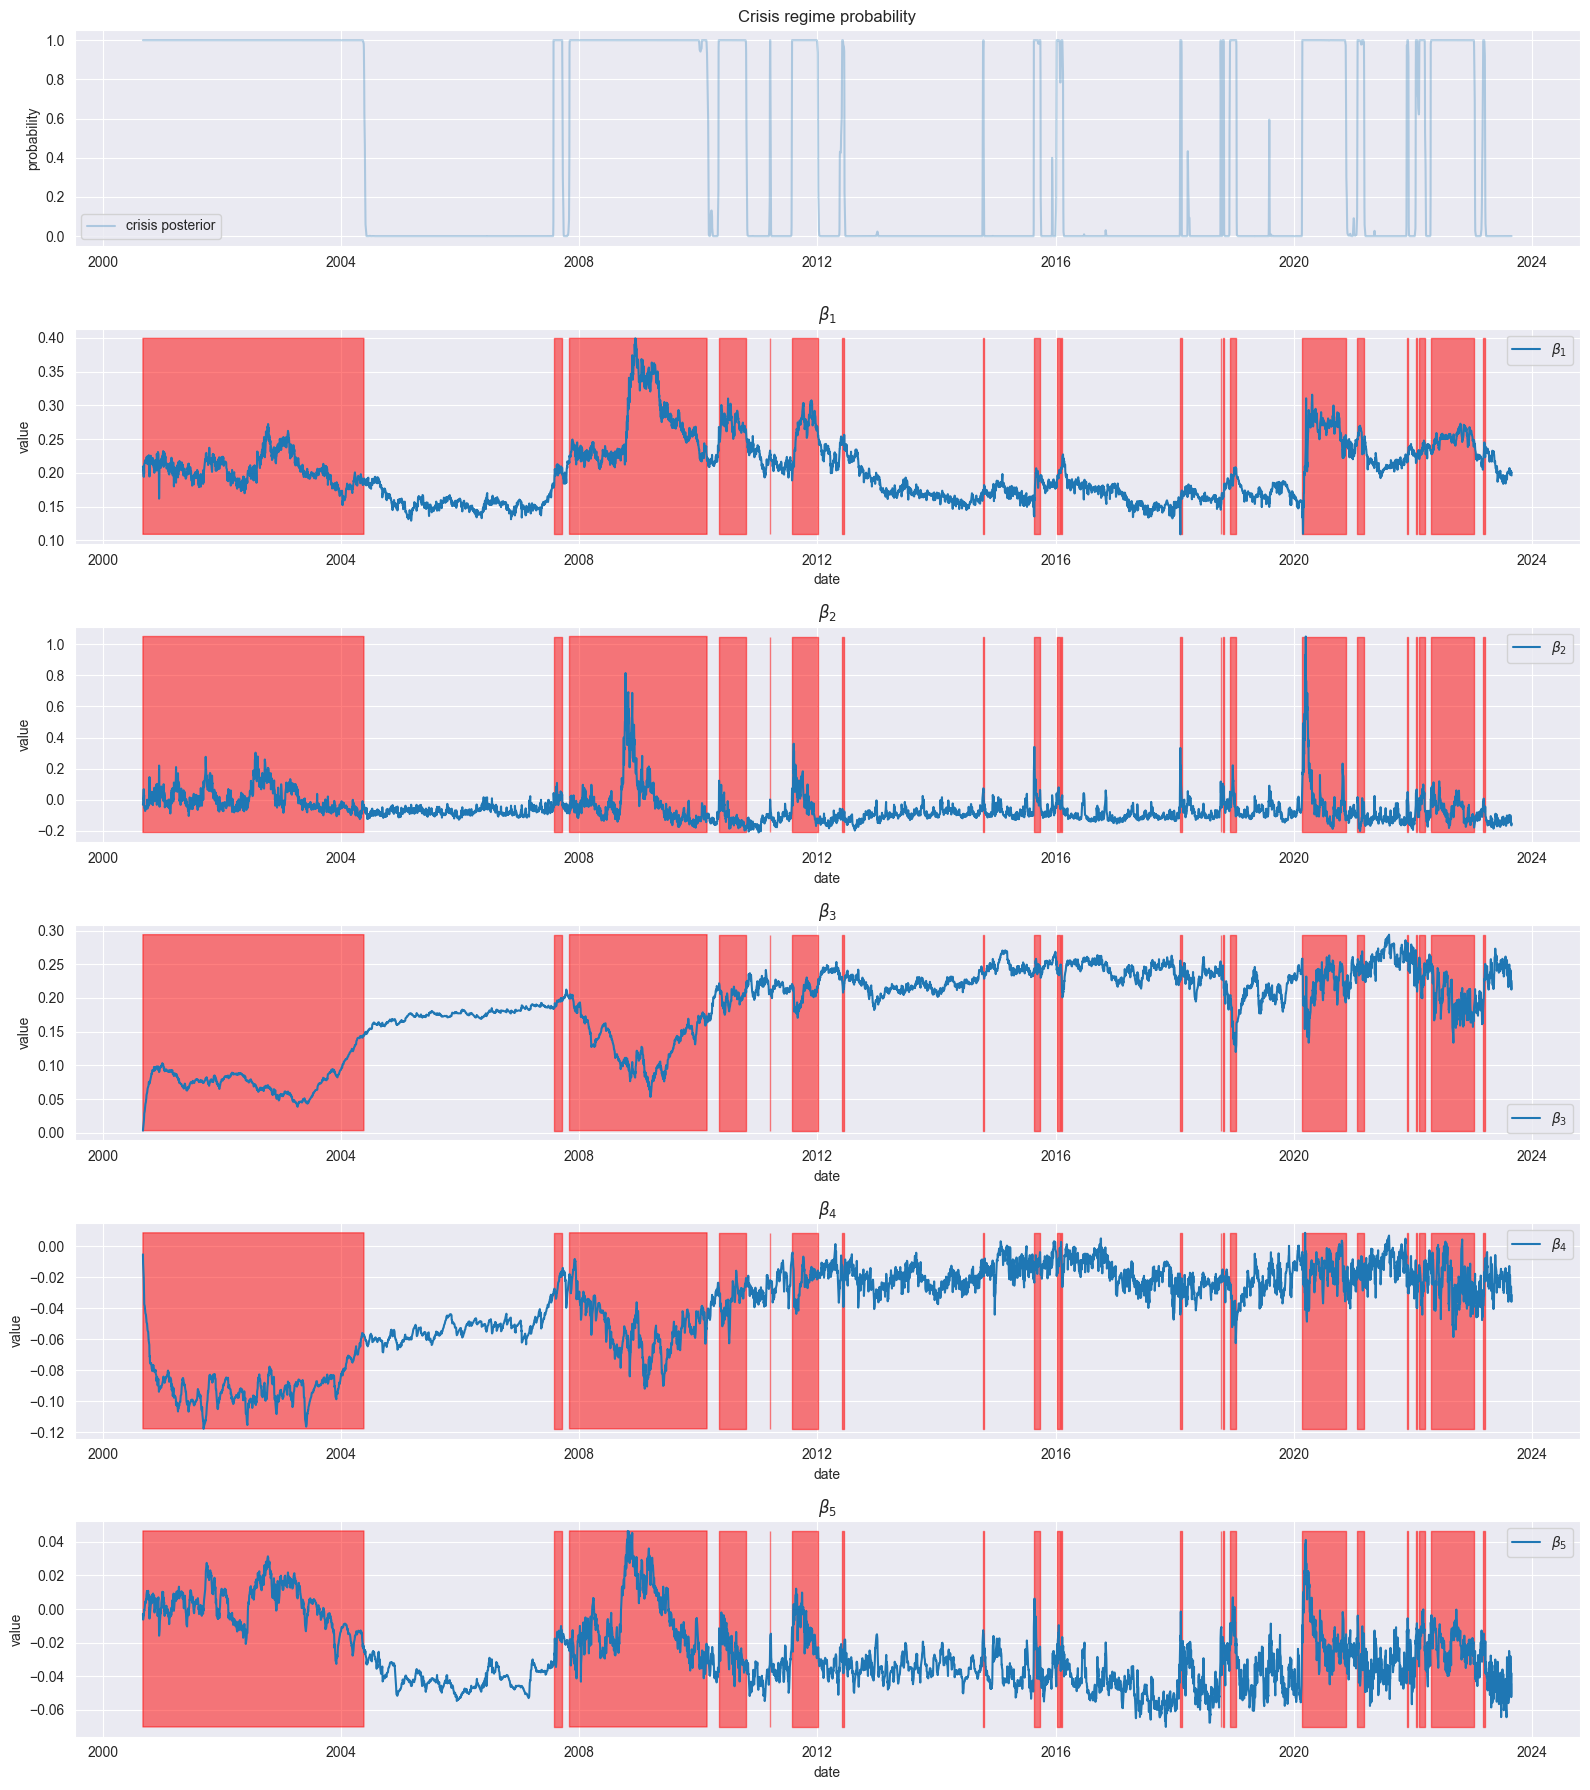

In [6]:
fig, axes = plt.subplots(6, 1, figsize=(16, 18))
# panel 1: crisis probability
axes[0].plot(beta["date"], beta["p_crisis"], label="crisis posterior", alpha=0.3)
axes[0].set_ylabel("probability")
axes[0].set_title("Crisis regime probability")
axes[0].legend()
# panels 2-6 : beta and shaded regime switching
crisis_mask = beta["state"].to_numpy() == 1
for b in range(1, 6):
    ts = beta[f"beta{b}"]
    sns.lineplot(x=beta["date"], y=ts, label=f"$\\beta_{b}$", ax=axes[b])
    axes[b].set_title(f'$\\beta_{b}$')
    axes[b].fill_between(x=beta["date"], y1=ts.min(), y2=ts.max(), where=crisis_mask, color="red", alpha=0.5,
                         step="post", label="crisis")
    axes[b].set_ylabel("value")
axes[5].set_xlabel("date")
plt.tight_layout()
plt.show()

## Regime specific covariance

We denote by $\Delta\beta_t$ the increments of the beta timeseries.
We estimate for each $s\in\{0, 1\}$
$$
\begin{aligned}
\mu_s&=\mathbb{E}\left[\Delta\beta_t\mid S_t=s\right]\\
\Sigma_s&=\text{Cov}\left[\Delta\beta_t\mid S_t=s\right]
\end{aligned}
$$
These will describe the dynamics of the betas in a particular regime.

In [7]:
increments = beta[beta_cols].diff().dropna()
increments["state"] = beta["state"][1:]
mean_dict = {s: increments.loc[increments["state"] == s][beta_cols].mean().values for s in [0, 1]}
cov_dict = {s: increments.loc[increments["state"] == s][beta_cols].cov().values for s in [0, 1]}

## Mixture Model and Simulations

We assume the following dynamic:
$$
\beta_{t+1} = \beta_t + \varepsilon_t
$$
with $\varepsilon$ drawn from the following mixture:
$$
\varepsilon_t \sim \begin{cases} \mathcal{N}\left(\mu_0,\Sigma_0\right)\quad\text{with probability}\quad\mathbb{P}\left(S_{t+1}=0\mid S_t\right) \\ \mathcal{N}\left(\mu_1,\Sigma_1\right)\quad\text{with probability}\quad\mathbb{P}\left(S_{t+1}=1\mid S_t\right) \end{cases}
$$

In [8]:
# Initialising simulations
np.random.seed(42)
N_PATHS = 1000
N_STEPS = 7
last_state = beta.iloc[-1]["state"]
beta0 = beta.iloc[-1][beta_cols].values.copy()
last_beta = beta.iloc[-1][beta_cols].values
total = np.zeros(5, dtype=float)
sim = dict()
states = dict()
# Simulating
for n in range(N_PATHS):
    current_simulation = last_beta.reshape(1, -1)
    current_states = [last_state]
    for i in range(N_STEPS):
        last_state = np.random.choice([0, 1], p=transmat[last_state])
        current_states.append(last_state)
        draw = np.random.multivariate_normal(mean_dict[last_state], cov_dict[last_state], 1)
        current_simulation = np.vstack((current_simulation, current_simulation[-1] + draw))
    total = total + current_simulation[-1]
    sim[n] = current_simulation
    states[n] = current_states
expected_beta = total / N_PATHS

## Volatility Surface visualisation

In [9]:
# choose current last date in df to define M and T grid
df = pd.read_parquet('../data.nosync/data.parquet')
day0 = df["date"].max()
df_day0 = df[df["date"] == day0].dropna(subset=["M", "YTM"])
del df

M_vals = np.linspace(df_day0["M"].min(), df_day0["M"].max(), 80)
T_vals = np.linspace(df_day0["YTM"].min(), df_day0["YTM"].max(), 80)
M_grid, T_grid = np.meshgrid(M_vals, T_vals)

IV_pred = sigma_model(M_grid, T_grid, expected_beta)

/Users/romain/Desktop/Class/MATH60610A/ProjectB/utils/utils.py:51: RuntimeWarning: overflow encountered in exp
  smirk = (1 - np.exp((3 * M) ** 3)) * np.log(T / T_MAX)


In [10]:
fig = go.Figure(
    data=[
        go.Surface(
            x=M_grid,
            y=T_grid,
            z=IV_pred
        )
    ]
)

fig.update_layout(
    title="Predicted implied volatility surface",
    scene=dict(
        xaxis_title="M",
        yaxis_title="YTM",
        zaxis_title="IV"
    )
)

fig.show()

## Risk Management

We put ourselves in the shoes of a market-maker that is short one vanilla put on the S&P500. We aim to characterise the risk of holding this position

---

First, choose one of the available options from the last day in our dataset and we compute it's Black&Scholes price using volatility generated by our surface model $\sigma(M, T, \beta)$

In [189]:
option = df_day0.loc[df_day0["cp_flag"] == 'P'].loc[df_day0["YTM"] > N_STEPS / 365].loc[df_day0["YTM"] < 0.5].iloc[-1]
F0 = option["F"]
T0 = option["YTM"]
K0 = option["strike_price"]
M0 = option["M"]
r0 = option["rf_decimal"] * 365
sigma0 = sigma_model(M0, T0, beta0)
P0 = BS_PUT(F0, K0, T0, r0, sigma0)
POSITION = -P0
POSITION

np.float64(-66.45936853477565)

The initial position is then:
$$
\Pi_t=-P_0=-\text{BSPut}\left(F, K, T, r, \sigma\left(M, T, \beta_0\right)\right)
$$

Then, for each simulated beta vector $\beta_T^{(i)}$, we compute it's corresponding volatility $\sigma_T^{(i)}$ and extract the option price
$$
P_T^{(i)}=\text{BSPut}\left(F, K, T, r, \sigma\left(M, T, \beta_T^{(i)}\right)\right)
$$

In [190]:
simulated_option_prices = []
simulated_vols = []
for i in range(N_PATHS):
    beta_T = sim[i][-1]
    vol = sigma_model(M0, T0 - N_STEPS / 365, beta_T)
    if vol <= 0:
        continue
    simulated_vols.append(vol)
    price = BS_PUT(F0, K0, T0 - N_STEPS / 365, r0, vol)
    simulated_option_prices.append(price)

We generate the vector of simulated PnLs as follow:
$$
\text{PnL}^{(i)}=-\left(P_T^{(i)}-P_0\right)
$$
Finally, we compute multiplte statistics on the distribution of the PnL

In [191]:
PnL = - (simulated_option_prices - P0)
# Basic distribution stats
mean_pnl = PnL.mean()
std_pnl = PnL.std(ddof=1)
skew_pnl = pd.Series(PnL).skew()
kurt_pnl = pd.Series(PnL).kurtosis()
# Loss probability
prob_loss = np.mean(PnL < 0)
# VaR and CVaR
alpha_95 = 0.95
alpha_99 = 0.99
var_95 = np.quantile(PnL, 1 - alpha_95)
var_99 = np.quantile(PnL, 1 - alpha_99)
cvar_95 = PnL[PnL <= var_95].mean()
cvar_99 = PnL[PnL <= var_99].mean()
# Extreme outcomes
min_pnl = PnL.min()
max_pnl = PnL.max()
stats = pd.DataFrame({
    "Metric": [
        "Mean", "Std", "Skew", "Kurtosis",
        "Prob_Loss",
        "VaR_95", "CVaR_95",
        "VaR_99", "CVaR_99",
        "Min_PnL", "Max_PnL"
    ],
    "Value": [
        mean_pnl, std_pnl, skew_pnl, kurt_pnl,
        prob_loss,
        var_95, cvar_95,
        var_99, cvar_99,
        min_pnl, max_pnl
    ]
})
stats

,Metric,Value
0,Mean,3.360217
1,Std,17.941751
2,Skew,-0.482544
3,Kurtosis,1.263851
4,Prob_Loss,0.380000
5,VaR_95,-29.229910
6,CVaR_95,-42.192412
7,VaR_99,-49.572214
8,CVaR_99,-56.429476
9,Min_PnL,-62.104268


We visualise the distribution of PnL alongside the computed statistics (mean, std, VaR, CVaR)

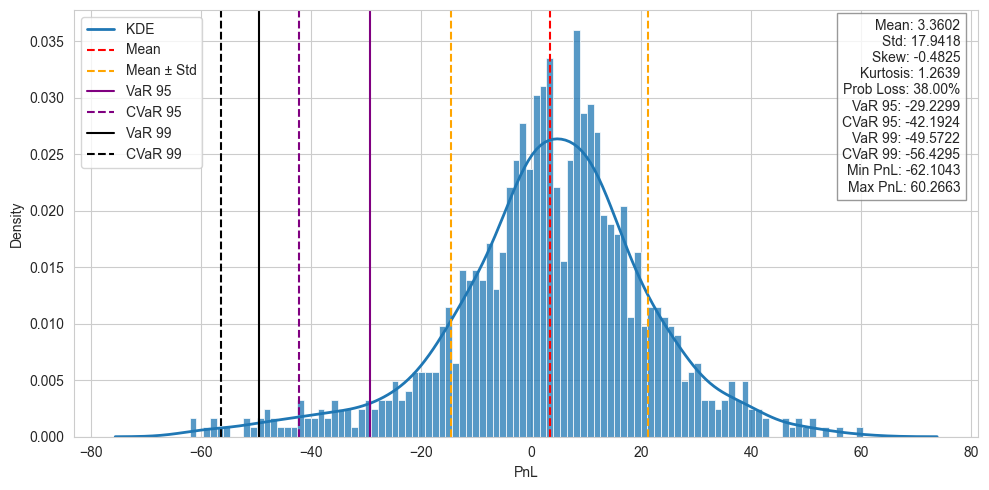

In [192]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(PnL, edgecolor="white", bins=100, stat="density")
sns.kdeplot(PnL, linewidth=2, label="KDE")
plt.axvline(mean_pnl, color="red", linestyle="dashed", label="Mean")
plt.axvline(mean_pnl + std_pnl, color="orange", linestyle="dashed", label="Mean ± Std")
plt.axvline(mean_pnl - std_pnl, color="orange", linestyle="dashed")
plt.axvline(var_95, color="purple", linestyle="solid", label="VaR 95")
plt.axvline(cvar_95, color="purple", linestyle="dashed", label="CVaR 95")
plt.axvline(var_99, color="black", linestyle="solid", label="VaR 99")
plt.axvline(cvar_99, color="black", linestyle="dashed", label="CVaR 99")
plt.xlabel("PnL")
textstr = (
    f"Mean: {mean_pnl:.4f}\n"
    f"Std: {std_pnl:.4f}\n"
    f"Skew: {skew_pnl:.4f}\n"
    f"Kurtosis: {kurt_pnl:.4f}\n"
    f"Prob Loss: {prob_loss:.2%}\n"
    f"VaR 95: {var_95:.4f}\n"
    f"CVaR 95: {cvar_95:.4f}\n"
    f"VaR 99: {var_99:.4f}\n"
    f"CVaR 99: {cvar_99:.4f}\n"
    f"Min PnL: {min_pnl:.4f}\n"
    f"Max PnL: {max_pnl:.4f}"
)
plt.text(
    0.98, 0.98, textstr,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray")
)
plt.legend()
plt.tight_layout()
plt.savefig("pnl_dist.pdf")
plt.show()

We also visualise the distribution of the simulated option prices

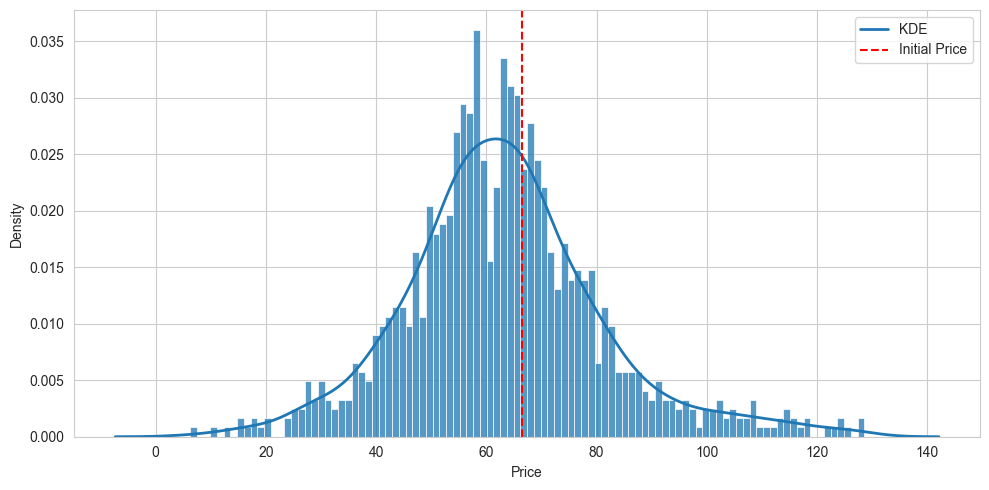

In [193]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(simulated_option_prices, stat="density", bins=100)
sns.kdeplot(simulated_option_prices, linewidth=2, label="KDE")
plt.axvline(x=P0, color='red', linestyle='dashed', label="Initial Price")
plt.xlabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig("price_dist.pdf")
plt.show()

We also visualise the distribution of the simulated volatilities

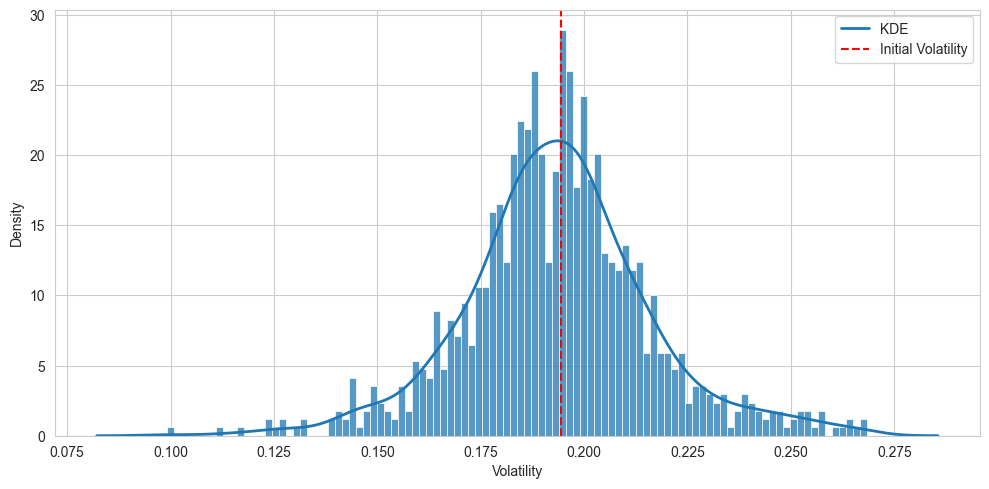

In [194]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(simulated_vols, stat="density", bins=100)
sns.kdeplot(simulated_vols, linewidth=2, label="KDE")
plt.axvline(x=sigma0, color='red', linestyle='dashed', label="Initial Volatility")
plt.xlabel("Volatility")
plt.legend()
plt.tight_layout()
plt.savefig("vol_dist.pdf")
plt.show()